## Import Packages

In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.image import ssim
from tensorflow.keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt

2024-04-14 17:10:59.306988: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load in Clean Images

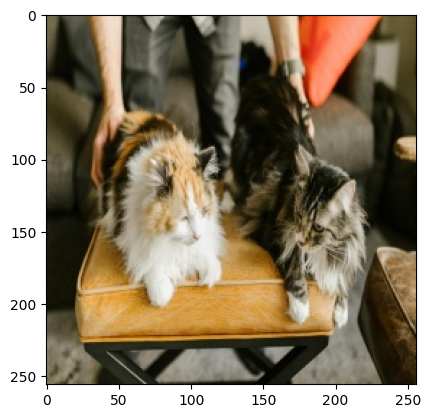

In [3]:
data_dir = "cats-resized256" # clean 256x256x3 images
file_names = os.listdir(data_dir)
images = []
for file_name in file_names:
    img = cv2.imread(os.path.join(data_dir, file_name)) # reads in BGR order
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # reverse back to RGB
    images.append(img)
images = np.array(images)
plt.imshow(images[0])

In [4]:
images.shape

(1035, 256, 256, 3)

## Create Noisy Images

In [5]:
noisy_images = np.clip(images + np.random.normal(loc=0, scale=25, size=images.shape), 0, 255).astype(np.uint8)

- `np.random.normal(loc=0, scale=25, size=images.shape)`: generates random Gaussian noise with a mean (loc) of 0 and a standard deviation (scale) of 25. The `size` parameter specifies the shape of the noise array, which matches the shape of the images array. So, for each pixel in each channel of each image, a random value is drawn from a Gaussian distribution with mean 0 and standard deviation 25.
- `images + np.random.normal(...)`: adds the generated noise to the original images since both images and the generated noise array have the same shape, meaning that the noise is added to each pixel value of each channel of each image.
- `np.clip(..., 0, 255)`: clips the pixel values of the noisy images to ensure they are within the valid range of (0, 255). Any pixel value below 0 is set to 0, and any pixel value above 255 is set to 255. This step is important to ensure that the resulting images are valid and can be displayed correctly.
- [Numpy source](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)

In [6]:
noisy_images.shape

(1035, 256, 256, 3)

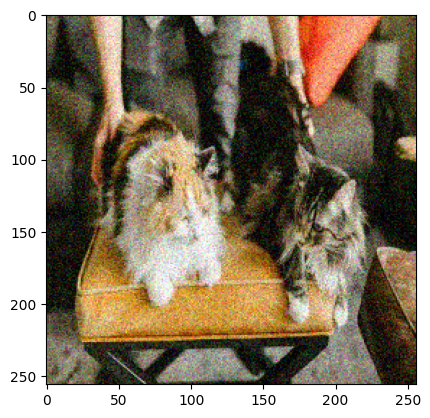

In [7]:
plt.imshow(noisy_images[0])

## Split into Training and Validation Sets

In [8]:
x_train, x_val, y_train, y_val = train_test_split(noisy_images, images, test_size=0.2, random_state=42)

print('X train size:', x_train.shape)
print('X validation size:', x_val.shape)

X train size: (828, 256, 256, 3)
X validation size: (207, 256, 256, 3)


## Normalize Data - 0 to 1 Range

In [9]:
x_train = x_train / 255.0
x_val = x_val / 255.0
y_train = y_train / 255.0
y_val = y_val / 255.0

## Create Structural Similarity Index (SSIM) Loss

In [10]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))

## Create Perceptual Loss Using Pre-trained VGG19
Perceptual loss is a type of loss function used in image generation tasks such as image denoising. Unlike traditional loss functions like Mean Squared Error (MSE), which measure pixel-wise differences between the predicted and ground truth images, perceptual loss focuses on capturing high-level visual features and semantics.

Perceptual loss is calculated by comparing the feature representations of the predicted and ground truth images extracted from a pre-trained deep neural network, often a CNN designed for image classification or feature extraction. The idea is to measure the difference in perceptual content between the generated image and the ground truth image rather than the difference in pixel values directly.

The VGG19 model, or any other pre-trained CNN model, is typically used to compute perceptual loss because these models have learned to extract meaningful features from images through their hierarchical layers. Specifically, perceptual loss is calculated by comparing the feature maps of intermediate layers of the pre-trained model for both the predicted and ground truth images.

In [26]:
# Pulling in part of VGG19 using pre-trained weights from ImageNet
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
vgg.trainable = False
model_vgg = Model(inputs=vgg.input, outputs=vgg.get_layer('block4_conv4').output)

In [33]:
def perceptual_loss(y_true, y_pred):
    # Compute feature representations
    true_features = model_vgg(y_true)
    pred_features = model_vgg(y_pred)
    
    # Compute mean squared error between feature representations
    mse = tf.reduce_mean(tf.square(true_features - pred_features))
    
    return mse

In [31]:
def custom_loss(y_true, y_pred):
    return perceptual_loss(y_true, y_pred)

## Building U-Net Model

In [12]:
def unet_model():
    inputs = Input(shape=(256, 256, 3))
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottom
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Concatenate()([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(3, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

## Compile the Model

In [32]:
model = unet_model()
model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['mse', ssim_loss, custom_loss])

## Train

In [15]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

The cell above handles the exception url fetch failure when getting VGG19 pre-trained model for the preceptual loss. Credit for this cell goes to [StackOverflow](https://stackoverflow.com/questions/47231408/downloading-resnet50-in-keras-generates-ssl-certificate-verify-failed).

In [37]:
history = model.fit(x_train, y_train, epochs=4, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/4
26/26 ━━━━━━━━━━━━━━━━━━━━ 2293s 88s/step - custom_loss: 1.2199 - loss: 0.0017 - mse: 0.0017 - ssim_loss: 0.1902 - val_custom_loss: 1.1531 - val_loss: 0.0015 - val_mse: 0.0015 - val_ssim_loss: 0.1906
Epoch 2/4
26/26 ━━━━━━━━━━━━━━━━━━━━ 2379s 92s/step - custom_loss: 1.1447 - loss: 0.0014 - mse: 0.0014 - ssim_loss: 0.1854 - val_custom_loss: 1.0954 - val_loss: 0.0015 - val_mse: 0.0015 - val_ssim_loss: 0.1903
Epoch 3/4
26/26 ━━━━━━━━━━━━━━━━━━━━ 2580s 100s/step - custom_loss: 1.1036 - loss: 0.0013 - mse: 0.0013 - ssim_loss: 0.1888 - val_custom_loss: 1.0584 - val_loss: 0.0016 - val_mse: 0.0016 - val_ssim_loss: 0.1896
Epoch 4/4
26/26 ━━━━━━━━━━━━━━━━━━━━ 2506s 97s/step - custom_loss: 1.0967 - loss: 0.0015 - mse: 0.0015 - ssim_loss: 0.1867 - val_custom_loss: 1.0597 - val_loss: 0.0015 - val_mse: 0.0015 - val_ssim_loss: 0.1821


## Evaluate with Validation Sets

In [38]:
val_loss, val_mse, val_ssim, val_perceptual_loss = model.evaluate(x_val, y_val)

print('Validation Loss:', val_loss)
print('Validation MSE:', val_mse)
print('Validation SSIM:', val_ssim)
print('Validation Perceptual Loss:', val_perceptual_loss)

7/7 ━━━━━━━━━━━━━━━━━━━━ 218s 31s/step - custom_loss: 1.0338 - loss: 0.0015 - mse: 0.0015 - ssim_loss: 0.1815
Validation Loss: 0.0015029266942292452
Validation MSE: 0.001502926810644567
Validation SSIM: 0.18211518228054047
Validation Perceptual Loss: 1.059699296951294


## Visualize Images with Metrics

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


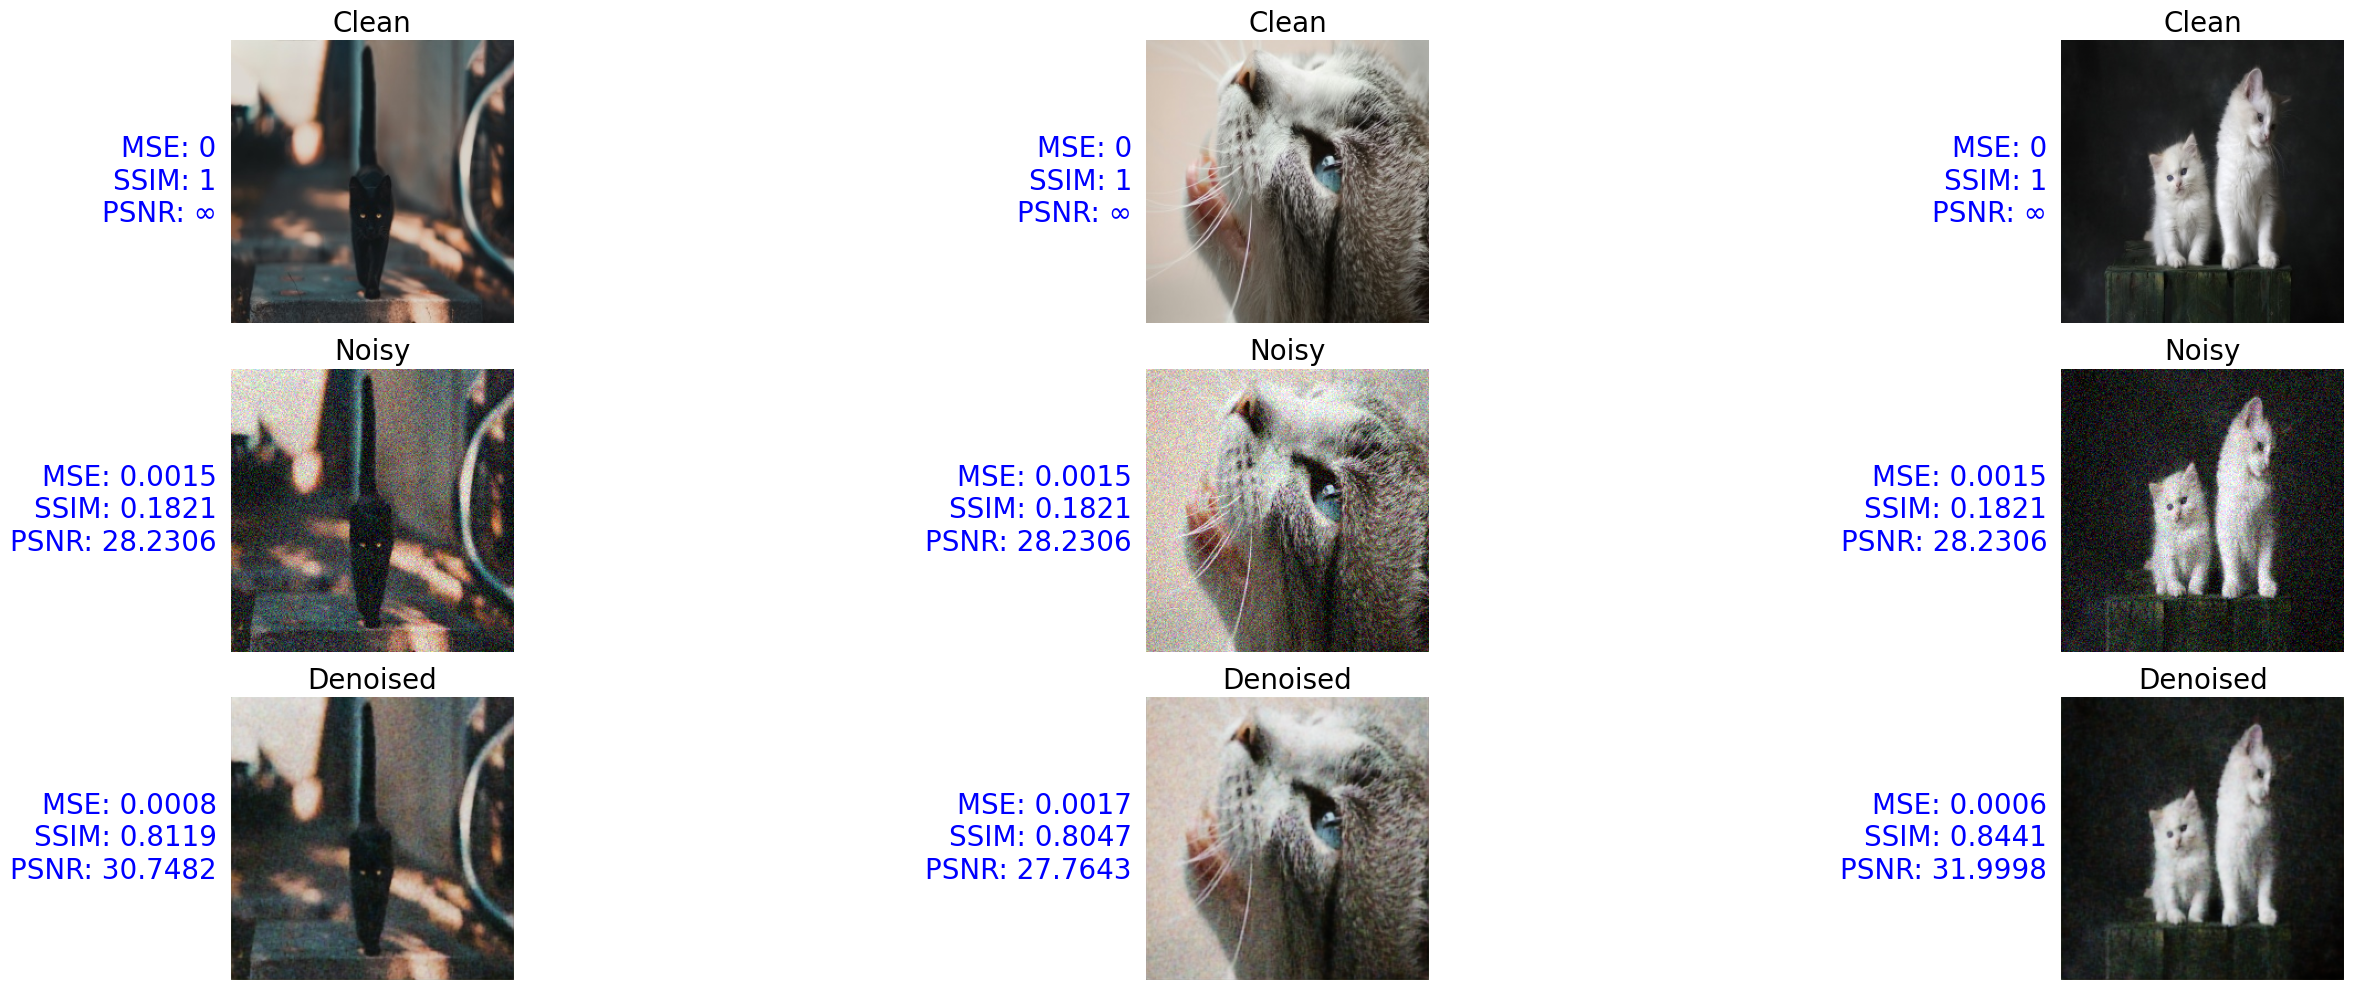

In [65]:
num_images = 3
plt.figure(figsize=(30, 10))
for i in range(num_images):
    # Clean Image
    plt.subplot(3, num_images, i+1)
    plt.imshow(y_val[i])
    plt.title('Clean', fontsize=20)
    plt.axis('off')
    plt.text(-0.05, 0.5, f"MSE: 0\nSSIM: 1\nPSNR: ∞", 
             fontsize=20, ha='right', va='center', transform=plt.gca().transAxes, color='blue')

    # Noisy Image
    plt.subplot(3, num_images, i+num_images+1)
    plt.imshow(x_val[i])
    plt.title('Noisy', fontsize=20)
    plt.axis('off')
    plt.text(-0.05, 0.5, f"MSE: {history.history['val_mse'][-1]:.4f}\nSSIM: {history.history['val_ssim_loss'][-1]:.4f}\nPSNR: {10 * np.log10(1/history.history['val_mse'][-1]):.4f}", 
             fontsize=20, ha='right', va='center', transform=plt.gca().transAxes, color='blue')

    # Denoised Image
    denoised_img = model.predict(np.expand_dims(x_val[i], axis=0)) #4D tensor float32 for ssim calculation
    plt.subplot(3, num_images, i+2*num_images+1)
    plt.imshow(denoised_img.squeeze())
    plt.title('Denoised', fontsize=20)
    plt.axis('off')
    # convert y_val to float32 for computations --4D tensor float32 for ssim calculation
    y_val_expanded = tf.expand_dims(y_val[i], axis=0) # (1, 256, 256, 3) tensor shape
    y_val_expanded = tf.image.convert_image_dtype(y_val_expanded, tf.float32) # convert to float32
    mse = np.mean(np.square(y_val_expanded - denoised_img))
    ssim_val = tf.image.ssim(y_val_expanded, denoised_img, max_val=1.0).numpy()
    psnr_val = 10 * np.log10(1/mse)
    plt.text(-0.05, 0.5, f"MSE: {mse:.4f}\nSSIM: {ssim_val[0]:.4f}\nPSNR: {psnr_val:.4f}", fontsize=20,
             ha='right', va='center',transform=plt.gca().transAxes, color='blue')

plt.tight_layout()
plt.savefig('unet-denoised-results.png')
plt.show()

In the code above, in order to use TensorFlow `ssim` it requires a 4D tensor on the images. This can be done with the help of Numpy or TensorFlow `expand_dims`. Expanding fulfills the batch parameter when calculating ssim, resulting in a 4D tensor of (1, 256, 256, 3). Lastly, both 4D tensors of `denoised_img` and `y_val[i]` need to be of float32. Once these requirements are met, then ssim can be calculated. Credit for this code goes to the [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/image/ssim). `ssim_val` can then be converted from a tensor to a numpy array and call index 0 to extract the ssim calculated value from the tensor.

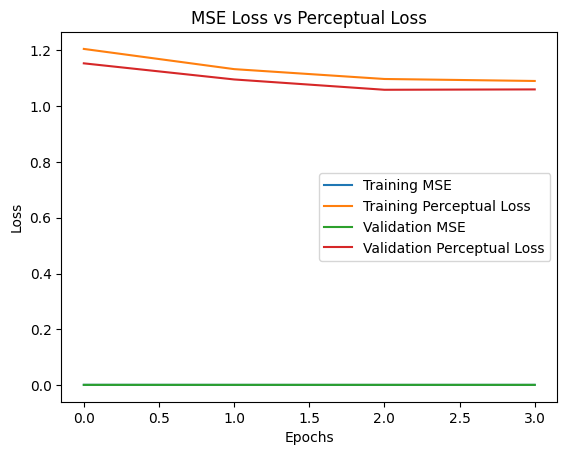

In [70]:
# Plotting MSE loss and Perceptual loss for training and validation data
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['custom_loss'], label='Training Perceptual Loss')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.plot(history.history['val_custom_loss'], label='Validation Perceptual Loss')


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MSE Loss vs Perceptual Loss')
plt.legend()
plt.savefig('MSE-Loss-vs-Perceptual-Loss.png')
plt.show()

Based on the plot above detailing training vs validation of MSE and Perceptual Loss, both training and validation MSE appear to be zero; however, they are so close to zero that the lines do not move. This may be caused by normalizing the pixel values to be between 0 and 1 before training. 

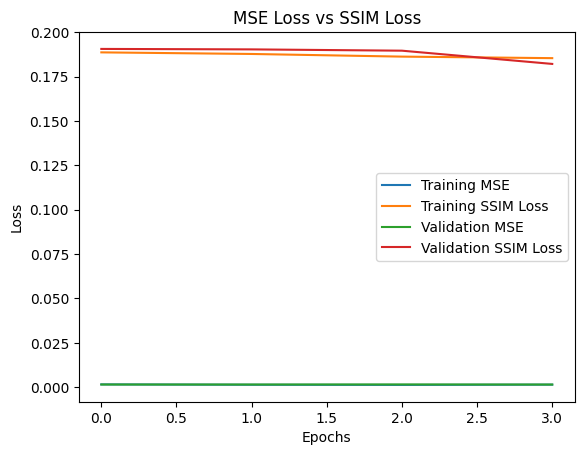

In [72]:
# Plotting MSE loss and SSIM for training and validation data
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['ssim_loss'], label='Training SSIM Loss')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.plot(history.history['val_ssim_loss'], label='Validation SSIM Loss')


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MSE Loss vs SSIM Loss')
plt.legend()
plt.savefig('MSE-Loss-vs-SSIM-Loss.png')
plt.show()

No major changes between the SSIM training and validation since Tensorflow function was used and referenced above under image plot.